In [381]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_formatting import *
from collections import Counter
import numpy as np
import time

import pandas as pd
import geopandas as gpd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.ticker import MaxNLocator

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools as it

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rc('axes', axisbelow=True)
%matplotlib inline

In [382]:
relabel_cols = {'24/7 Congregate Settings':'Congregate Settings',
 'Alcohol and Drug Treatment':'Congregate Settings',
 'Apartment Complexes':'Congregate Settings',
 'Assembly Locations':'Industrial Settings',
 'Automotive/Dealership':'Other Workplaces',
 'Bar':'Bars',
 'Bars':'Bars',
 'Behavioral/Mental Health Facility':'Congregate Settings',
 'Camp':'Organized Athletics/Camps',
 'Camp -not sports camp':'Organized Athletics/Camps',
 'Casino':'Casino',
 'Child Care':'Childcare & Pre-Schools',
 'Child Daycare':'Childcare & Pre-Schools',
 'Church/Temple/Religious Location':'Religious Services/Event',
 'College/University':'Higher Education',
 'Colleges & Universities':'Higher Education',
 'Community Event':'Social/Community Setting',
 'Construction Business':'Construction Settings',
 'Construction Site':'Construction Settings',
 'Correctional Facility':'Correctional Facility',
 'Corrections':'Correctional Facility',
 'Day Care - Adult':'Congregate Settings',
 'Day Care - Child':'Childcare & Pre-Schools',
 'Factory/Manufacturer':'Industrial Settings',
 'Farm Related Business':'Food Production Facility',
 'Festival/Fair':'Social/Community Setting',
 'First Responder Workplaces':'Healthcare',
 'Food Processing':'Food Production Facility',
 'Food Production Facility':'Food Production Facility',
 'Funeral':'Social/Community Setting',
 'Group Home':'Congregate Settings',
 'Gym/Fitness Setting':'Gym/Fitness Setting',
 'Gym/Fitness/Dance Facility':'Gym/Fitness Setting',
 'Home Gathering':'Social/Community Setting',
 'Hospice/Home Health':'Healthcare',
 'Hospital':'Healthcare',
 'Hospitals':'Healthcare',
 'Hotel/Motel':'Travel/Transit',
 'Household':'Household',
 'Industrial Setting':'Industrial Settings',
 'Industrial Settings':'Industrial Settings',
 'K-12 Schools':'K-12 Schools',
 'Long Term Care Facilities':'Congregate Settings',
 'Mass Transit (airplane, bus, train, etc)':'Travel/Transit',
 'Medical Clinic/Dental Office':'Healthcare',
 'Migrant Farm Camp':'Food Production Facility',
 'Military Facility':'Industrial Settings',
 'Office Setting':'Office Setting',
 'Office Space':'Office Setting',
 'Offices':'Office Setting',
 'Organized Athletics/Camps':'Organized Athletics/Camps',
 'Other':'Other',
 'Other Food Establishments':'Restaurants & Other Food Establishments',
 'Other Healthcare':'Healthcare',
 'Other Workplaces':'Other Workplaces',
 'Other Worksite':'Other Workplaces',
 'Personal Services':'Other',
 'Places of Worship':'Religious Services/Event',
 'Pre-School':'Childcare & Pre-Schools',
 'Primary/Secondary School':'K-12 Schools',
 'Recreation':'Social/Community Setting',
 'Recreation/Cultural':'Social/Community Setting',
 'Religious Services/Event':'Religious Services/Event',
 'Restaurant':'Restaurants & Other Food Establishments',
 'Restaurants & Food Courts':'Restaurants & Other Food Establishments',
 'Retail & Services':'Retail Setting',
 'Retail Setting':'Retail Setting',
 'Retail/Sales':'Retail Setting',
 'Senior Living':'Senior Living',
 'Senior/Independent Living Facilities/Housing':'Senior Living',
 'Shelter, Homeless':'Shelters',
 'Sheltered Care Facility':'Shelters',
 'Shelters':'Shelters',
 'Ship/Boat':'Travel/Transit',
 'Short-term Rehabilitation Facility':'Congregate Settings',
 'Social Event':'Social/Community Setting',
 'Social Gatherings':'Social/Community Setting',
 'Sports Team - Not School Associated':'Organized Athletics/Camps',
 'Transitional Facility - not correctional':'Congregate Settings',
 'Travel & Lodging':'Travel/Transit',
 'Vocational School':'Higher Education',
 'Warehouse/Distribution Centers':'Other Workplaces',
 'Wedding':'Social/Community Setting',
 'Workplace':'Other Workplaces',
'Adult Sports Club/Team':"Organized Athletics/Camps",
 'Agriculture - Other':"Food Production Facility",
 'Banquet Facility':"Social/Community Setting",
 'Bar/Tavern/Brewery':"Bars",
 'Casino':"Casino",
 'Caterer':"Social/Community Setting",
 'Child Care Center':"Childcare & Pre-Schools",
 'College/University':"Higher Education",
 'Construction Company/Contractor':"Construction Settings",
 'Construction Site':"Construction Settings",
 'Convenience/Corner Store':"Retail Setting",
 'Correctional, Other':"Correctional Facility",
 'Day Camp':"Organized Athletics/Camps",
 'Distribution Center/Business':"Industrial Settings",
 'Fair/Festival/Temp. Mobile Event':"Social/Community Setting",
 'Farm/Dairy':"Food Production Facility",
 'Federal Prison':"Correctional Facility",
 'Food Distribution':"Industrial Settings",
 'Food Manufacturing/Packaging':"Food Production Facility",
 'Food Warehouse':"Food Production Facility",
 'Grocery Store':"Retail Setting",
 'Healthcare - Acute Care Hospital':"Healthcare",
 'Healthcare - Alcohol/Drug Abuse Treatment (inpatient)':"Congregate Settings",
 'Healthcare - Alcohol/Drug Abuse Treatment (outpatient)':"Healthcare",
 'Healthcare - Ambulatory Surgery Center':"Healthcare",
 'Healthcare - Assisted Living':"Senior Living",
 'Healthcare - Combined Care':"Congregate Settings",
 'Healthcare - Facility for Developmentally Disabled (inpatient)':"Congregate Settings",
 'Healthcare - Facility for Developmentally Disabled (outpatient)':"Healthcare",
 'Healthcare - Group Home':"Senior Living",
 'Healthcare - Hospice':"Senior Living",
 'Healthcare - Independent Living Facility':"Congregate Settings",
 'Healthcare - Long-term Acute Care':"Congregate Settings",
 'Healthcare - Memory Care':"Healthcare",
 'Healthcare - Outpatient':"Healthcare",
 'Healthcare - Psychiatric Hospital':"Healthcare",
 'Healthcare - Rehab Facility':"Healthcare",
 'Healthcare - Skilled Nursing':"Healthcare",
 'Home Maintenance Services':"Construction Settings",
 'Homeless Shelter':"Congregate Settings",
 'Hotel/Lodge/Resort':"Travel/Transit",
 'Indoor Entertainment/Rec':"Social/Community Setting",
 'Jail':"Correctional Facility",
 'Law Enforcement - Other':"Correctional Facility",
 'Law Enforcement Administration':"Correctional Facility",
 'Materials Supplier':"Industrial Settings",
 'Meat Processing/Packaging':"Food Production Facility",
 'Non-Food Manufacturer/Warehouse':"Industrial Settings",
 'Office/Indoor Workspace':"Office Setting",
 'Other':"Other",
 'Outdoor Entertainment/Rec':"Social/Community Setting",
 'Overnight Camp':"Organized Athletics/Camps",
 'Personal Services':"Other Workplaces",
 'Religious Facility':"Religious Services/Event",
 'Restaurant - Buffet':"Restaurants & Other Food Establishments",
 'Restaurant - Fast Food':"Restaurants & Other Food Establishments",
 'Restaurant - Other':"Restaurants & Other Food Establishments",
 'Restaurant - Sit Down':"Restaurants & Other Food Establishments",
 'Retailer':"Retail Setting",
 'School Administration':"K-12 Schools",
 'School K-12':"K-12 Schools",
 'School/College Dorm':"Higher Education",
 'Social Gathering':"Social/Community Setting",
 'Specialty Food Retailer':"Restaurants & Other Food Establishments",
 'State Prison':"Correctional Facility",
 'Trade School':"Higher Education",
 'Travel':"Travel/Transit",
 'Youth Sports/Activities':'Organized Athletics/Camps'}

In [383]:
today = time.strftime("%Y-%m-%d")

month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-06', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATERANGE = DATE_DF['date'].tolist()

date_dict = {DATERANGE[i]:i for i in range(len(DATERANGE))}

In [384]:
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('../../universities/data/client_secret.json', scope)
client = gspread.authorize(creds)

outbreak_data = client.open("COVID-outbreak_settings")
ma_data = outbreak_data.worksheet('massachusetts_raw')
la_data = outbreak_data.worksheet('louisiana_raw')
il_data = outbreak_data.worksheet('illinois_raw')

ma_df = pd.DataFrame(ma_data.get_all_records())
la_df = pd.DataFrame(la_data.get_all_records())
il_df = pd.DataFrame(il_data.get_all_records())

outbreak_dfs_tmp = [ma_df, la_df, il_df]
states = ['Massachusetts','Louisiana','Illinois']
outbreak_dfs = []
for oi, odf in enumerate(outbreak_dfs_tmp):
    odf = odf[['date', 'setting', 'raw_new_clusters', 'raw_new_cases', 
               'raw_total_clusters', 'raw_total_cases']].copy()
    odf.loc[odf['raw_new_clusters']=='','raw_new_clusters'] = np.nan
    odf.loc[odf['raw_new_cases']=='','raw_new_cases'] = np.nan
    odf.loc[odf['raw_total_clusters']=='','raw_total_clusters'] = np.nan
    odf.loc[odf['raw_total_cases']=='','raw_total_cases'] = np.nan
    odf['state'] = states[oi]
    outbreak_dfs.append(odf)

outbreak_df = pd.concat(outbreak_dfs).reset_index().iloc[:,1:]
# outbreak_df

In [385]:
co_data = outbreak_data.worksheet('colorado_raw')
co_df = pd.DataFrame(co_data.get_all_records())
co_df = co_df[['date', 'setting', 'raw_new_cases', 'raw_new_clusters', 'raw_new_deaths', 'county']]
co_df = co_df.merge(DATE_DF[['date','week']], how='left', on='date')
co_df['state'] = 'Colorado'

In [386]:
co_df['grouped_setting'] = [relabel_cols[i] for i in co_df['setting']]
co_dfg = co_df.groupby(['week','grouped_setting','state']).agg({'raw_new_clusters':'sum',
                                                                'raw_new_cases':'sum',
                                                                }).reset_index()
co_dfg['new_cases_per'] = co_dfg['raw_new_cases'] / co_dfg['raw_new_clusters']
# co_dfg.groupby('grouped_setting').agg({'new_cases_per':np.nanmean}).reset_index()

In [387]:
outbreak_df['grouped_setting'] = [relabel_cols[i] for i in outbreak_df['setting']]
outbreak_df = outbreak_df.merge(DATE_DF[['date','week']], how='left', on='date')
outbreak_df = outbreak_df.loc[outbreak_df['state']!='Illinois'].copy()

In [388]:
gbcols = ['week','grouped_setting','state']
agcols = ['raw_new_clusters','raw_new_cases','raw_total_clusters','raw_total_cases']
out_dfg = outbreak_df.groupby(gbcols).agg({i:'sum' for i in agcols}).reset_index()

In [389]:
out_g = out_dfg.groupby(['grouped_setting','week']).agg({i:'sum' for i in agcols}).reset_index()

In [390]:
out_dfg = out_dfg.loc[out_dfg['raw_new_clusters']>0].copy()
out_dfg['new_cases_per'] = out_dfg['raw_new_cases'] / out_dfg['raw_new_clusters']


In [391]:
out_dfg = out_dfg[['week','grouped_setting','state','raw_new_clusters',
                   'raw_new_cases','new_cases_per']].copy()

In [392]:
out_dfg = pd.concat([out_dfg,co_dfg]).reset_index().iloc[:,1:]

In [393]:
def get_ci(df, col, gb_col='date', percentile='95'):
    if percentile == '99':
        cival = 2.576
    if percentile == '95':
        cival = 1.96
    if percentile == '90':
        cival = 1.645
    if percentile == '80':
        cival = 1.282

    df_stats = df.groupby(gb_col)[col].agg([np.nanmean,'count',np.nanstd])
    ci95_hi = []
    ci95_lo = []
    for i in df_stats.index:
        m, c, s = df_stats.loc[i]
        ci95_hi.append(m + cival*s/np.sqrt(c))
        ci95_lo.append(m - cival*s/np.sqrt(c))
    df_stats['ci95_hi'] = ci95_hi
    df_stats['ci95_lo'] = ci95_lo

    return df_stats.reset_index()

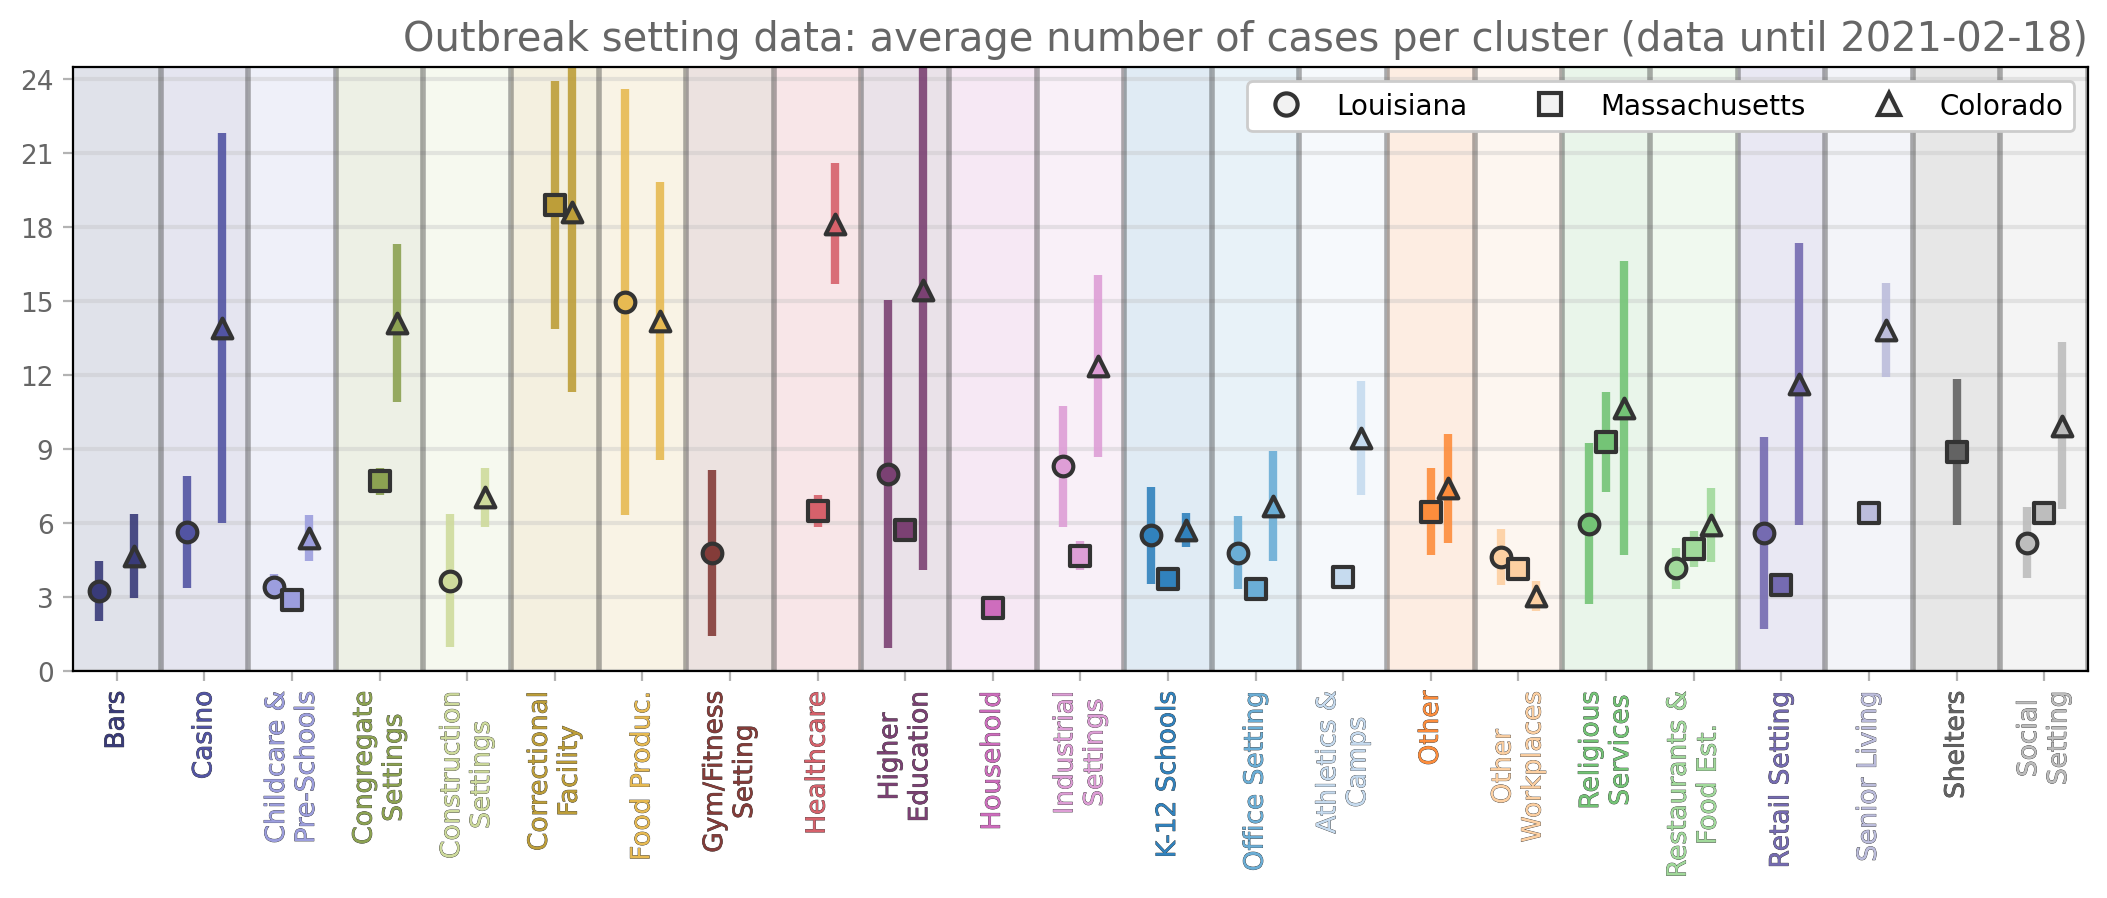

In [424]:
fig, ax = plt.subplots(1,1,figsize=(13,4), dpi=200)

cols = list(plt.cm.tab20b(np.linspace(0,1,12)))
cols = cols + list(plt.cm.tab20c(np.linspace(0,1,12)))
labs = dict(zip(['Bars', 'Casino', 'Childcare & Pre-Schools', 'Congregate Settings',
                 'Construction Settings', 'Correctional Facility', 'Food Production Facility',
                 'Gym/Fitness Setting', 'Healthcare', 'Higher Education', 'Household',
                 'Industrial Settings', 'K-12 Schools', 'Office Setting', 'Organized Athletics/Camps',
                 'Other', 'Other Workplaces', 'Religious Services/Event',
                 'Restaurants & Other Food Establishments', 'Retail Setting', 'Senior Living',
                 'Shelters', 'Social/Community Setting', 'Travel/Transit'],
                ['Bars', 'Casino', 'Childcare &\nPre-Schools', 'Congregate\nSettings',
                 'Construction\nSettings', 'Correctional\nFacility', 'Food Produc.',
                 'Gym/Fitness\nSetting', 'Healthcare', 'Higher\nEducation', 'Household',
                 'Industrial\nSettings', 'K-12 Schools', 'Office Setting', 'Athletics &\nCamps',
                 'Other', 'Other\nWorkplaces', 'Religious\nServices',
                 'Restaurants &\nFood Est.', 'Retail Setting', 'Senior Living',
                 'Shelters', 'Social\nSetting', 'Travel/Transit']))

marks = {'Massachusetts':'s','Louisiana':'o','Colorado':'^'}
xvsl = [-0.2, 0.0, 0.2]

for si,st in enumerate(out_dfg['state'].unique()):
    out_dfg_st = out_dfg.loc[out_dfg['state']==st].copy()
    dat_i = get_ci(out_dfg_st, 'new_cases_per', gb_col='grouped_setting', percentile='90')
    for oi, ou in enumerate(sorted(out_dfg['grouped_setting'].unique())[:-1]):
        out_dfg_st = out_dfg.loc[out_dfg['state']==st].copy()
        if ou in ['Organized Athletics/Camps','Casino','Higher Education','Travel/Transit','Correctional Facility','Healthcare','Senior Living','Congregate Settings']:
            if st == 'Colorado' and ou in ['Higher Education','Correctional Facility']:
                out_dfg_st['raw_new_clusters'] = out_dfg_st['raw_new_clusters'] * 5
                if ou == 'Higher Education':
                    out_dfg_st['raw_new_clusters'] = out_dfg_st['raw_new_clusters'] * 1.5
                out_dfg_st['new_cases_per'] = out_dfg_st['raw_new_cases']/out_dfg_st['raw_new_clusters']
            elif st == 'Colorado' and ou in ['Casino','Healthcare', 'Senior Living','Congregate Settings']:
                out_dfg_st['raw_new_clusters'] = out_dfg_st['raw_new_clusters'] * 1.5
                out_dfg_st['new_cases_per'] = out_dfg_st['raw_new_cases']/out_dfg_st['raw_new_clusters']

            dat_i = get_ci(out_dfg_st, 'new_cases_per', gb_col='grouped_setting', percentile='80')
        else:
            dat_i = get_ci(out_dfg_st, 'new_cases_per', gb_col='grouped_setting', percentile='95')            

        d = dat_i.loc[dat_i['grouped_setting']==ou].copy()
        ax.fill_between([oi-0.5, oi+0.5], 0, 25, lw=0, alpha=0.05, color=cols[oi], zorder=0)
        m = marks[out_dfg_st['state'].unique()[0]]
        if d.shape[0]>0:
            ax.vlines(oi+xvsl[si], d['ci95_lo'].values[0], d['ci95_hi'].values[0],
                      lw=3, alpha=0.9, color=cols[oi],zorder=1)
            ax.scatter([oi+xvsl[si]], [d['nanmean'].values[0]],
                       marker=m, ec='.2', color=cols[oi],zorder=2, lw=1.5, s=50)

ax.vlines(np.arange(0.5, 24, 1), 0, 25, color='.2', lw=2, alpha=0.4)
ax.tick_params(labelcolor='.4',color='.7',labelsize=9.5)
ax.set_xticks(list(range(out_dfg['grouped_setting'].nunique())))
ax.set_xlim(-0.5, out_dfg['grouped_setting'].nunique()-1.5)
ax.set_xticklabels([labs[i] for i in sorted(out_dfg['grouped_setting'].unique())],rotation=90)
for oi, ou in enumerate(sorted(out_dfg['grouped_setting'].unique())[:-1]):
    ax.get_xticklabels()[oi].set_color(cols[oi])
    ax.get_xticklabels()[oi].set_path_effects(path_effects=[path_effects.Stroke(linewidth=0.25,
                                            foreground='.2'), path_effects.Normal()])
    
ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=9))

ax.grid(axis='y',linewidth=1.5,color='.75',alpha=0.35)
ax.set_ylim(0, 24.5)

from matplotlib.lines import Line2D
 
legend_elements = [Line2D([0], [0], marker='o', lw=0, color='.2', label='Louisiana',
                          markerfacecolor='.95', markersize=8, markeredgewidth=1.5),
                   Line2D([0], [0], marker='s', lw=0, color='.2', label='Massachusetts',
                          markerfacecolor='.95', markersize=8, markeredgewidth=1.5),
                   Line2D([0], [0], marker='^', lw=0, color='.2', label='Colorado',
                          markerfacecolor='.95', markersize=8, markeredgewidth=1.5)]

ax.legend(handles=legend_elements, loc=1, framealpha=1.0, fontsize='medium', ncol=3)

ax.set_title('Outbreak setting data: average number of cases per cluster '+\
             '(data until %s)'%outbreak_df['date'].max(),
             ha='right', x=1, color='.4', fontsize='x-large')


# plt.savefig('../figs/pngs/outbreaks_ma_la.png',dpi=425,bbox_inches='tight')
plt.show()

____________________________________

In [104]:
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('../../universities/data/client_secret.json', scope)
client = gspread.authorize(creds)

florida_schools = client.open("COVID-data_FloridaSchools")
fl_data = florida_schools.worksheet('florida_schools')
fl_df = pd.DataFrame(fl_data.get_all_records(default_blank=np.nan))
fl_df['school'] = fl_df['school'].str.replace('. ','.',regex=False)
fl_df['school'] = fl_df['school'].str.replace('.',' ',regex=False)
fl_df['school'] = fl_df['school'].str.replace("'","",regex=False)
fl_df.loc[(~fl_df['school'].str.contains('TOUSSAINT')),
          'school'] = fl_df.loc[(~fl_df['school'].str.contains('TOUSSAINT')),
                                                 'school'].str.replace("SAINT ","ST ",regex=False)

gbcols = ['school','county','type','date','start_date']
agcols = ['new_cases','new_cases_students','new_cases_teachers','new_cases_staff','new_cases_unknown',
          'cumulative_cases','cumulative_cases_students','cumulative_cases_teachers',
          'cumulative_cases_staff','cumulative_cases_unknown','symptoms_yes','symptoms_no','symptoms_idk']

school_dfs = []
startdate_df = fl_df[['date','start_date']].drop_duplicates().sort_values('date').reset_index().iloc[:,1:]

school_counties = fl_df[['school','county','type']].drop_duplicates()

for i in list(school_counties.index):
    sch = school_counties['school'][i]
    cou = school_counties['county'][i]
    k12 = school_counties['type'][i]
#     print(sch)

    start_df = DATE_DF.loc[DATE_DF['date'].isin(sorted(fl_df_g['date'].unique()))][['date','week']]
    start_df = start_df.reset_index().iloc[:,1:]
    start_df = start_df.merge(startdate_df, how='left', on='date')

    fl_df_i = fl_df.loc[(fl_df['school']==sch)&(fl_df['county']==cou)].copy().reset_index().iloc[:,1:]
    fl_df_i = fl_df_i[[i for i in fl_df_i.columns if i != 'start_date']]
    
    odf = start_df.merge(fl_df_i, how='left', on='date')
    odf['school'] = sch.title()
    odf['county'] = cou.title()
    odf['type'] = k12
    odf = odf[gbcols+agcols]

    school_dfs.append(odf)

school_dfs = pd.concat(school_dfs).reset_index().iloc[:,1:]
school_dfs

A L MEBANE MIDDLE
A QUINN JONES CENTER
ABIDING SAVIOR LUTHERAN PRESCHOOL
ABRAHAM LINCOLN MIDDLE
ALACHUA ACADEMY
ALACHUA DISTRICT OFFICE
ALACHUA ELEMENTARY
ALACHUA LEARNING ACADEMY ELEMENTARY
ALACHUA LEARNING ACADEMY MIDDLE
AMIKIDS
ARCHER ELEMENTARY
BOULWARE SPRINGS CHARTER
BUCHHOLZ HIGH
C W NORTON ELEMENTARY
CARING & SHARING LEARNING SCHOOL
CAROLYN BEATRICE PARKER ELEMENTARY
CHESTER SHELL ELEMENTARY
CORNERSTONE ACADEMY
COUNTRYSIDE CHRISTIAN
EARLY LEARNING ACADEMY AT DUVAL
EASTSIDE HIGH
EXPRESSIONS LEARNING ARTS ACADEMY
F W BUCHHOLZ HIGH
FAMILY LIFE ACADEMY
FIRST CHRISTIAN ACADEMY
FORT CLARKE MIDDLE
GAINESVILLE COUNTRY DAY SCHOOL
GAINESVILLE HIGH
GLEN SPRINGS ELEMENTARY
HAWTHORNE MIDDLE/HIGH
HIDDEN OAK ELEMENTARY
HIGH SPRINGS COMMUNITY SCHOOL
HOWARD W BISHOP MIDDLE
IDYLWILD ELEMENTARY
JOSEPH WILLIAMS ELEMENTARY
KANAPAHA MIDDLE
KIMBALL WILES ELEMENTARY
LAKE FOREST ELEMENTARY
LANIAKEA MONTESSORI
LAWTON M CHILES ELEMENTARY
LITTLEWOOD ELEMENTARY
LIVING SPRINGS ACADEMY
MARJORIE KINNAN RAWLIN

,school,county,type,date,start_date,new_cases,new_cases_students,new_cases_teachers,new_cases_staff,new_cases_unknown,cumulative_cases,cumulative_cases_students,cumulative_cases_teachers,cumulative_cases_staff,cumulative_cases_unknown,symptoms_yes,symptoms_no,symptoms_idk
0,A L Mebane Middle,Alachua,k12,2020-09-26,2020-09-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A L Mebane Middle,Alachua,k12,2020-10-03,2020-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A L Mebane Middle,Alachua,k12,2020-10-17,2020-10-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A L Mebane Middle,Alachua,k12,2020-10-24,2020-10-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A L Mebane Middle,Alachua,k12,2020-10-31,2020-10-25,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128818,Washington District Office,Washington,k12,2021-01-16,2021-01-10,NaN,NaN,NaN,NaN,NaN,6.0,0.0,0.0,3.0,3.0,6,0.0,0.0
128819,Washington District Office,Washington,k12,2021-01-23,2021-01-17,1.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,4.0,3.0,7,0.0,0.0
128820,Washington District Office,Washington,k12,2021-01-30,2021-01-24,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,4.0,3.0,7,0.0,0.0
128821,Washington District Office,Washington,k12,2021-02-06,2021-01-31,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,4.0,3.0,7,0.0,0.0


In [118]:
school_dfs.loc[school_dfs['symptoms_yes']=='###','symptoms_yes'] = school_dfs.loc[school_dfs['symptoms_yes']=='###']['cumulative_cases'].astype(float)-\
                                                    school_dfs.loc[school_dfs['symptoms_yes']=='###']['symptoms_no'].astype(float) - \
                                                    school_dfs.loc[school_dfs['symptoms_yes']=='###']['symptoms_idk'].astype(float)

In [119]:
fl_df_g = school_dfs.groupby(gbcols).agg({i:np.nansum for i in agcols}).reset_index()

,school,county,type,date,start_date,new_cases,new_cases_students,new_cases_teachers,new_cases_staff,new_cases_unknown,cumulative_cases,cumulative_cases_students,cumulative_cases_teachers,cumulative_cases_staff,cumulative_cases_unknown,symptoms_yes,symptoms_no,symptoms_idk
0,A Childs Place Montessori,Duval,k12,2020-09-26,2020-09-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A Childs Place Montessori,Duval,k12,2020-10-03,2020-09-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A Childs Place Montessori,Duval,k12,2020-10-17,2020-10-11,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,A Childs Place Montessori,Duval,k12,2020-10-24,2020-10-18,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,A Childs Place Montessori,Duval,k12,2020-10-31,2020-10-25,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126295,Zora Neale Hurston Elementary,Dade,k12,2021-01-16,2021-01-10,0.0,0.0,0.0,0.0,0.0,11.0,10.0,0.0,0.0,1.0,7.0,4.0,0.0
126296,Zora Neale Hurston Elementary,Dade,k12,2021-01-23,2021-01-17,0.0,0.0,0.0,0.0,0.0,11.0,10.0,0.0,0.0,1.0,7.0,4.0,0.0
126297,Zora Neale Hurston Elementary,Dade,k12,2021-01-30,2021-01-24,2.0,1.0,0.0,0.0,1.0,13.0,11.0,0.0,0.0,2.0,8.0,5.0,0.0
126298,Zora Neale Hurston Elementary,Dade,k12,2021-02-06,2021-01-31,2.0,2.0,0.0,0.0,0.0,15.0,13.0,0.0,0.0,2.0,9.0,6.0,0.0


In [123]:
test = fl_df_g.groupby(['type','date']).agg({i:'sum' for i in agcols}).reset_index()

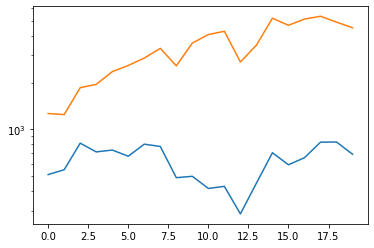

In [130]:
plt.semilogy(test.loc[test['type']=='university']['new_cases'].values)
plt.semilogy(test.loc[test['type']=='k12']['new_cases'].values)

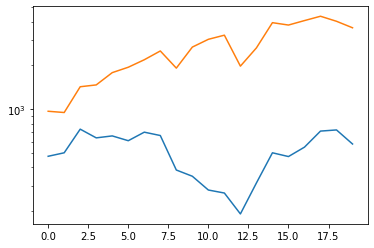

In [129]:
plt.semilogy(test.loc[test['type']=='university']['new_cases_students'].values)
plt.semilogy(test.loc[test['type']=='k12']['new_cases_students'].values)

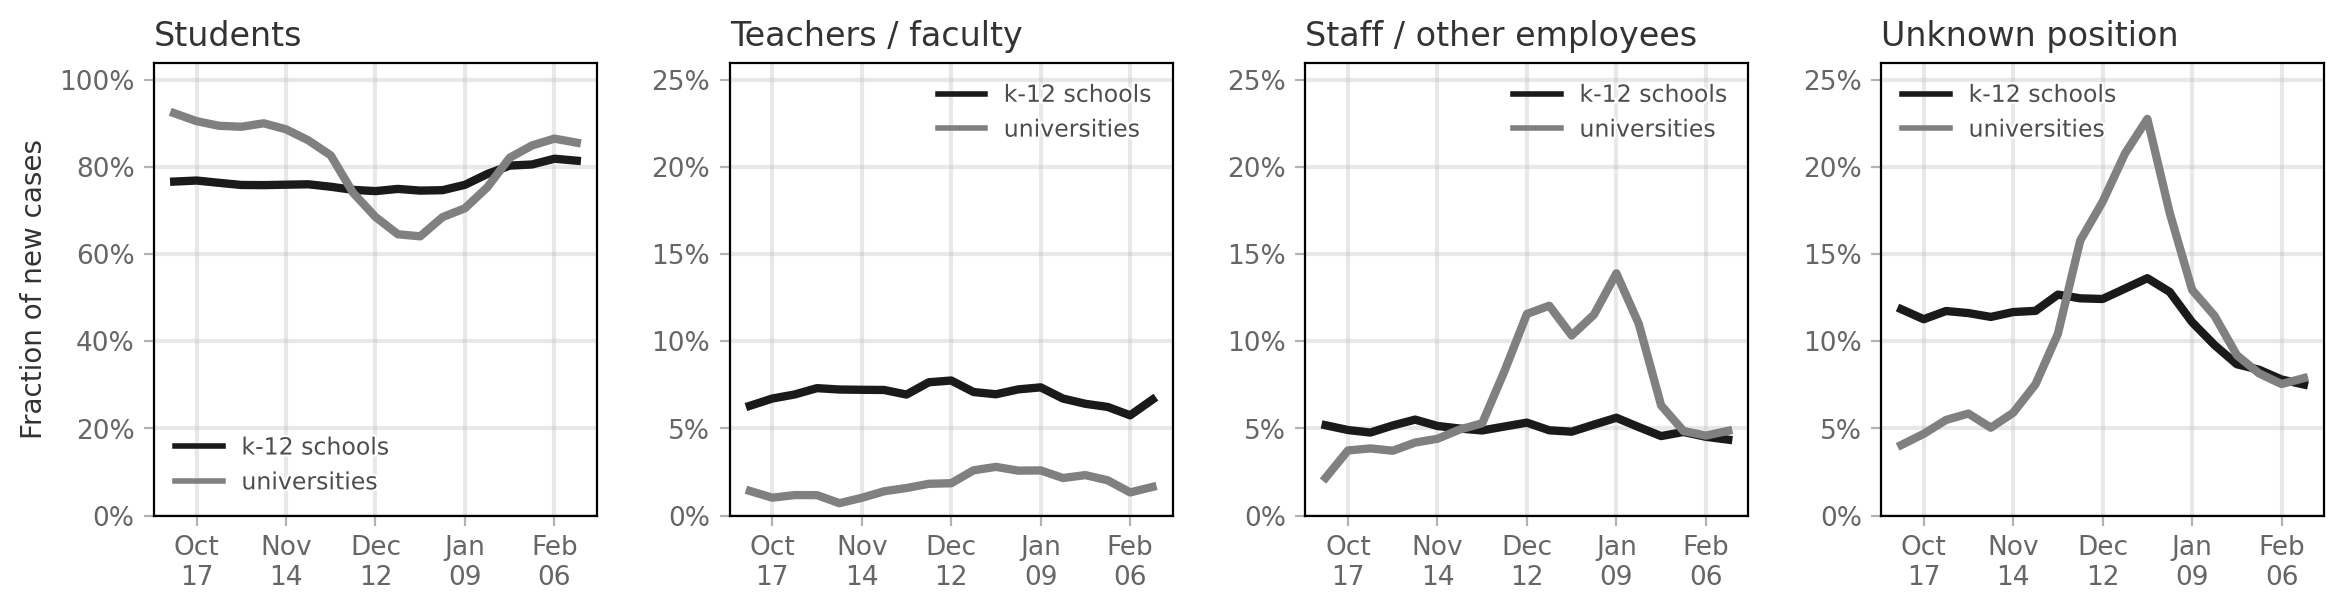

In [199]:
fig, ax = plt.subplots(1,4,figsize=(14,3),dpi=200)#, sharey=True)
plt.subplots_adjust(wspace=0.3)

lw = 3
cols = ['.5','.1']

ax[0].plot(test.loc[test['type']=='k12']['new_cases_students'].rolling(window=2).mean().values/\
             test.loc[test['type']=='k12']['new_cases'].rolling(window=2).mean().values,
           color=cols[1], label='k-12 schools', lw=lw)
ax[0].plot(test.loc[test['type']=='university']['new_cases_students'].rolling(window=2).mean().values/\
           test.loc[test['type']=='university']['new_cases'].rolling(window=2).mean().values,
           color=cols[0], label='universities', lw=lw)

ax[1].plot(test.loc[test['type']=='k12']['new_cases_teachers'].rolling(window=2).mean().values/\
             test.loc[test['type']=='k12']['new_cases'].rolling(window=2).mean().values,
           color=cols[1], label='k-12 schools', lw=lw)
ax[1].plot(test.loc[test['type']=='university']['new_cases_teachers'].rolling(window=2).mean().values/\
             test.loc[test['type']=='university']['new_cases'].rolling(window=2).mean().values,
           color=cols[0], label='universities', lw=lw)

ax[2].plot(test.loc[test['type']=='k12']['new_cases_staff'].rolling(window=2).mean().values/\
             test.loc[test['type']=='k12']['new_cases'].rolling(window=2).mean().values,
           color=cols[1], label='k-12 schools', lw=lw)
ax[2].plot(test.loc[test['type']=='university']['new_cases_staff'].rolling(window=2).mean().values/\
             test.loc[test['type']=='university']['new_cases'].rolling(window=2).mean().values,
           color=cols[0], label='universities', lw=lw)

ax[3].plot(test.loc[test['type']=='k12']['new_cases_unknown'].rolling(window=2).mean().values/\
             test.loc[test['type']=='k12']['new_cases'].rolling(window=2).mean().values,
           color=cols[1], label='k-12 schools', lw=lw)
ax[3].plot(test.loc[test['type']=='university']['new_cases_unknown'].rolling(window=2).mean().values/\
             test.loc[test['type']=='university']['new_cases'].rolling(window=2).mean().values,
           color=cols[0], label='universities', lw=lw)

ax[0].set_ylabel('Fraction of new cases', color='.2')
ax[0].set_title('Students', x=0, ha='left', color='.2')
ax[1].set_title('Teachers / faculty', x=0, ha='left', color='.2')
ax[2].set_title('Staff / other employees', x=0, ha='left', color='.2')
ax[3].set_title('Unknown position', x=0, ha='left', color='.2')

dates = test['date'].unique()
for ai, a in enumerate(fig.axes):
    leg = a.legend(fontsize=8.5, markerscale=0.5, framealpha=0)
    leg.get_lines()[0].set_linewidth(lw/1.5)
    leg.get_lines()[1].set_linewidth(lw/1.5)
    for text in leg.get_texts():
        text.set_color('.3')
        text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                               path_effects.Normal()])

    if ai == 0:
        a.set_yticks(np.linspace(0,1,6))
        a.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
        a.set_ylim(0,1.04)
    else:
        a.set_yticks(np.linspace(0,0.25,6))
        a.set_yticklabels(['0%','5%','10%','15%','20%','25%'])
        a.set_ylim(0, 0.26)

    a.tick_params(labelcolor='.4',color='.7',labelsize=9.5)
    a.grid(linewidth=1.5,color='.75',alpha=0.35)
    a.set_xticks(list(range(len(dates)))[2::4])
    a.set_xticklabels([month_dict[i[5:7]]+"\n"+i[8:] for i in sorted(dates)[2::4]])
#     a.set_xlim(-0.5, out_dfg['grouped_setting'].nunique()-1.5)

plt.show()

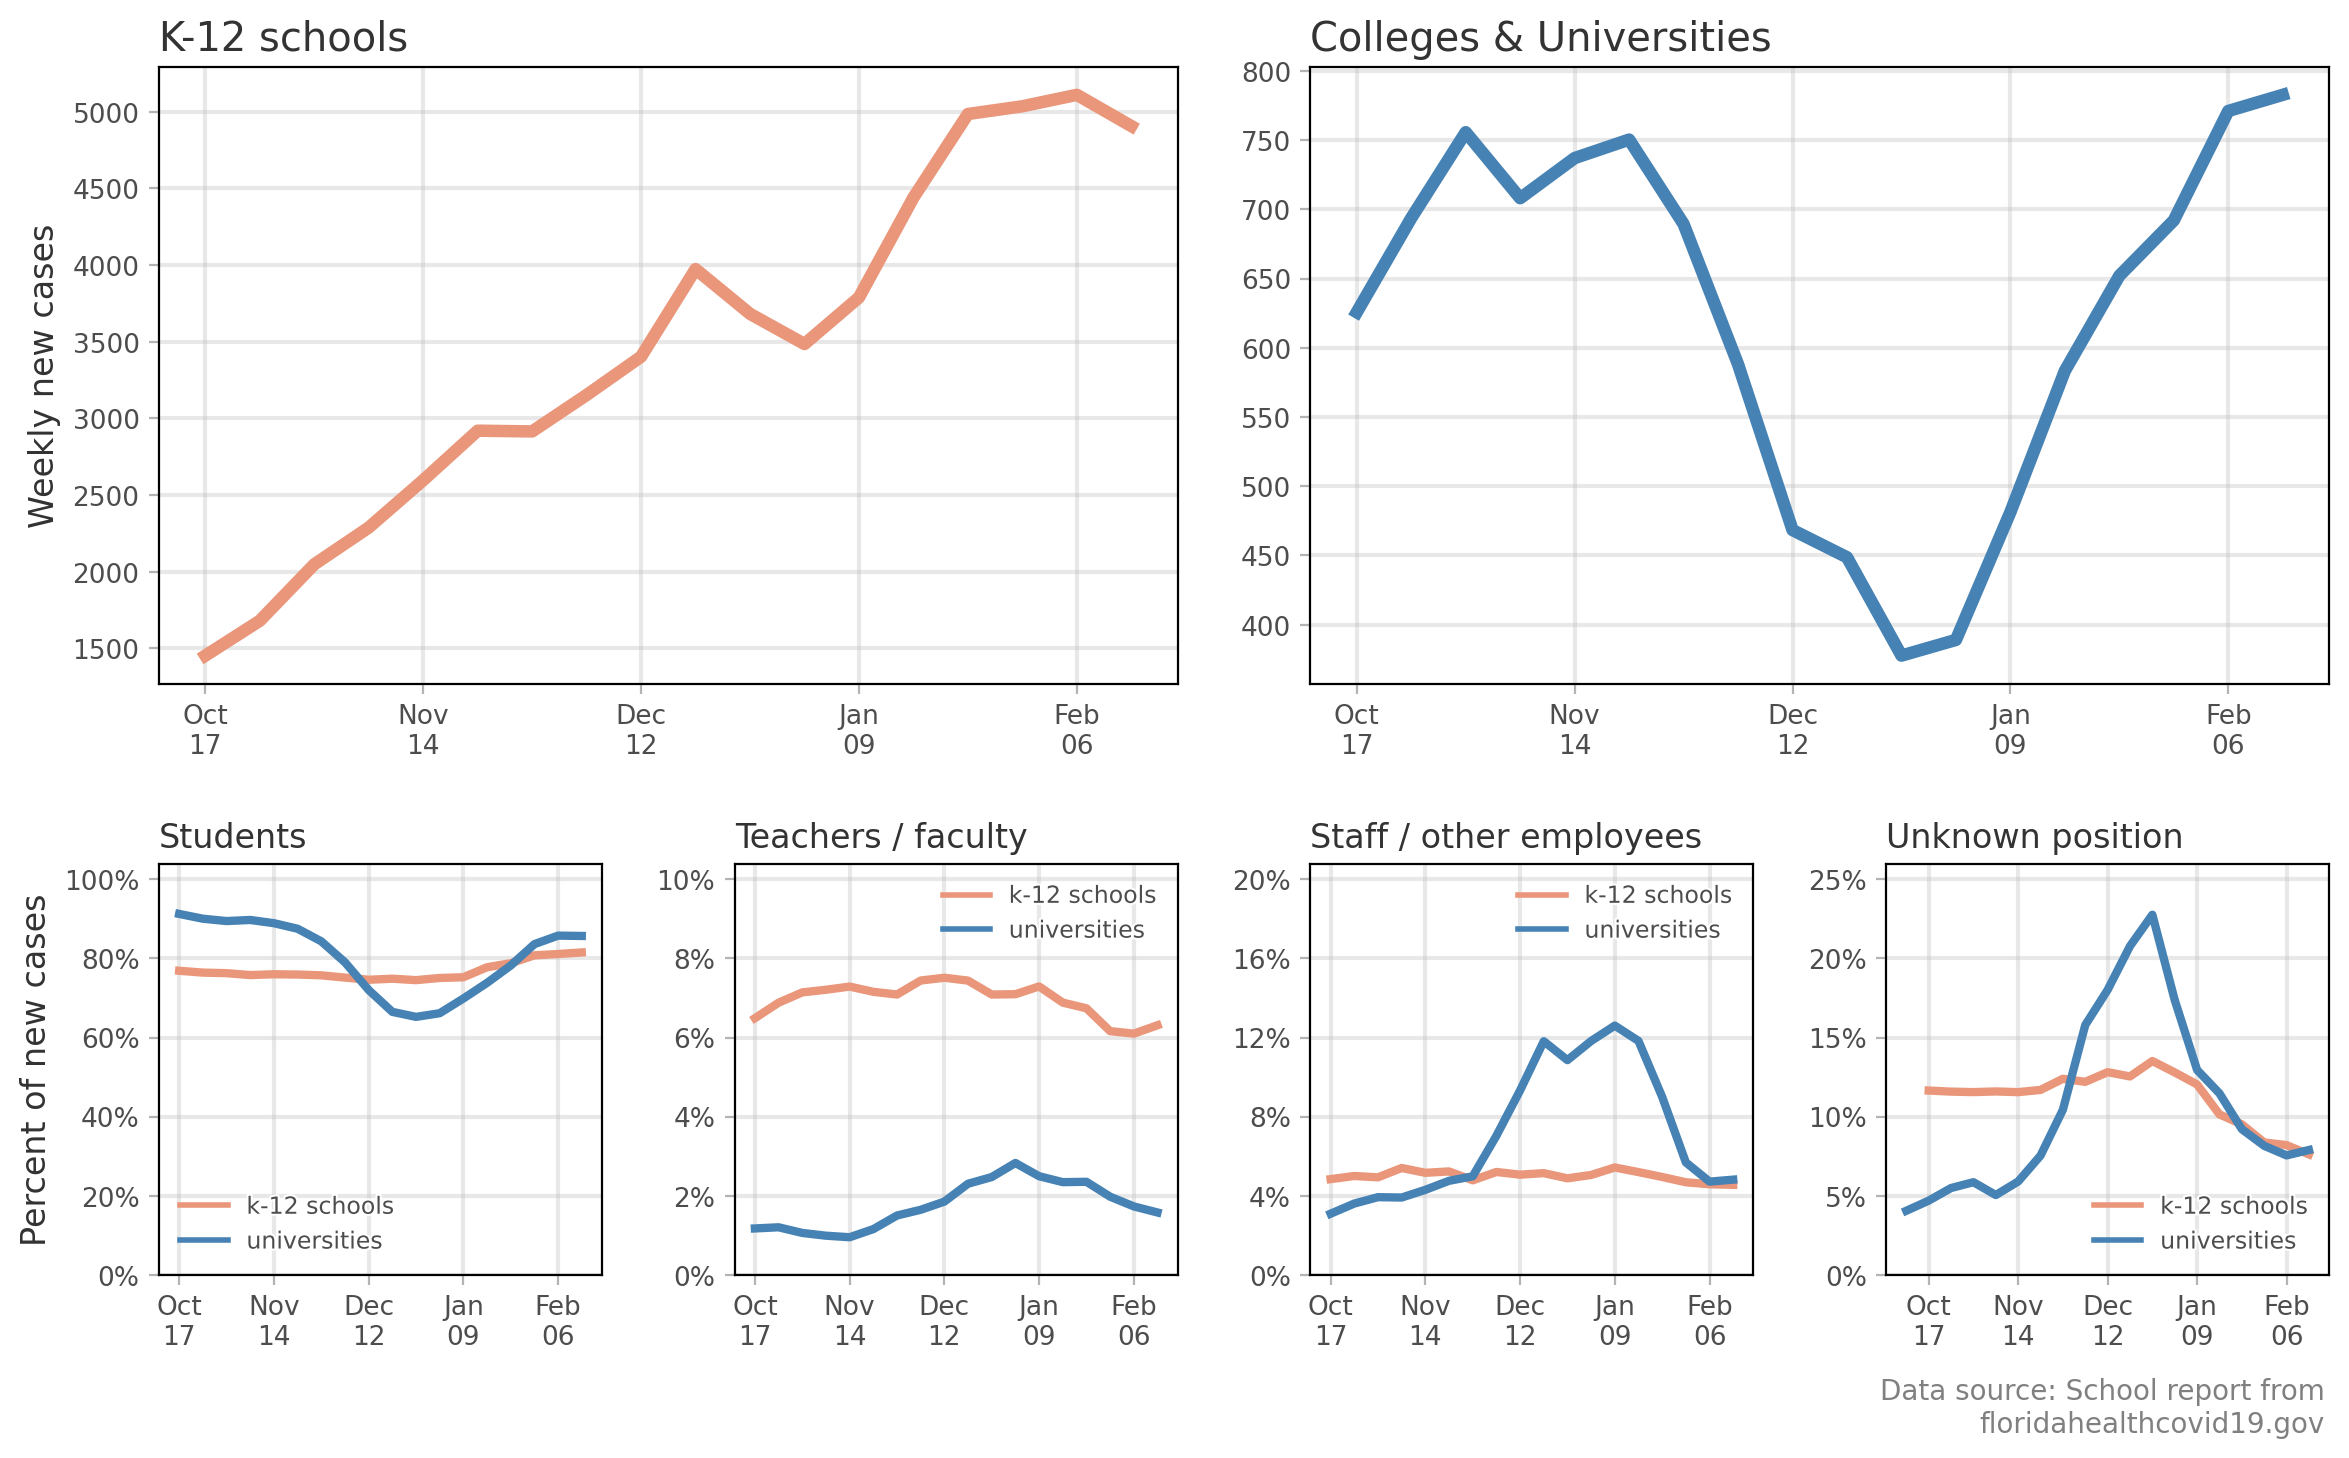

In [332]:
fig, ax = plt.subplots(2,4,figsize=(14,8),dpi=200,gridspec_kw={'height_ratios':[3,2]})
plt.subplots_adjust(wspace=0.3,hspace=0.35)

lw = 3
cols = ['steelblue','darksalmon']
wid = 3

gs = ax[0, 0].get_gridspec()
for a in ax[0:1, 0:1].flatten():
    a.remove()
axbig1 = fig.add_subplot(gs[0:1, 0:2])
for a in ax[0:1, 2:3].flatten():
    a.remove()
axbig2 = fig.add_subplot(gs[0:1, 2:4])

axbig1.plot(test.loc[test['type']=='k12']['new_cases'].rolling(window=wid).mean().values,
           color=cols[1], lw=lw*1.5)
axbig2.plot(test.loc[test['type']=='university']['new_cases'].rolling(window=wid).mean().values,
           color=cols[0], lw=lw*1.5)

ax[(1,0)].plot(test.loc[test['type']=='k12']['new_cases_students'].rolling(window=wid).mean().values/\
             test.loc[test['type']=='k12']['new_cases'].rolling(window=wid).mean().values,
           color=cols[1], label='k-12 schools', lw=lw)
ax[(1,0)].plot(test.loc[test['type']=='university']['new_cases_students'].rolling(window=wid).mean().values/\
           test.loc[test['type']=='university']['new_cases'].rolling(window=wid).mean().values,
           color=cols[0], label='universities', lw=lw)

ax[(1,1)].plot(test.loc[test['type']=='k12']['new_cases_teachers'].rolling(window=wid).mean().values/\
             test.loc[test['type']=='k12']['new_cases'].rolling(window=wid).mean().values,
           color=cols[1], label='k-12 schools', lw=lw)
ax[(1,1)].plot(test.loc[test['type']=='university']['new_cases_teachers'].rolling(window=wid).mean().values/\
             test.loc[test['type']=='university']['new_cases'].rolling(window=wid).mean().values,
           color=cols[0], label='universities', lw=lw)

ax[(1,2)].plot(test.loc[test['type']=='k12']['new_cases_staff'].rolling(window=wid).mean().values/\
             test.loc[test['type']=='k12']['new_cases'].rolling(window=wid).mean().values,
           color=cols[1], label='k-12 schools', lw=lw)
ax[(1,2)].plot(test.loc[test['type']=='university']['new_cases_staff'].rolling(window=wid).mean().values/\
             test.loc[test['type']=='university']['new_cases'].rolling(window=wid).mean().values,
           color=cols[0], label='universities', lw=lw)

ax[(1,3)].plot(test.loc[test['type']=='k12']['new_cases_unknown'].rolling(window=wid).mean().values/\
             test.loc[test['type']=='k12']['new_cases'].rolling(window=wid).mean().values,
           color=cols[1], label='k-12 schools', lw=lw)
ax[(1,3)].plot(test.loc[test['type']=='university']['new_cases_unknown'].rolling(window=2).mean().values/\
             test.loc[test['type']=='university']['new_cases'].rolling(window=2).mean().values,
           color=cols[0], label='universities', lw=lw)

axbig1.set_ylabel('Weekly new cases', color='.2', fontsize='large')
axbig1.set_title('K-12 schools', x=0, ha='left', color='.2', fontsize='x-large')
axbig2.set_title('Colleges & Universities', x=0, ha='left', color='.2', fontsize='x-large')

ax[(1,0)].set_ylabel('Percent of new cases', color='.2', fontsize='large')
ax[(1,0)].set_title('Students', x=0, ha='left', color='.2')
ax[(1,1)].set_title('Teachers / faculty', x=0, ha='left', color='.2')
ax[(1,2)].set_title('Staff / other employees', x=0, ha='left', color='.2')
ax[(1,3)].set_title('Unknown position', x=0, ha='left', color='.2')

ax[(1,3)].text(0.99,-0.25, 'Data source: School report from'+\
               '\nfloridahealthcovid19.gov',transform=ax[(1,3)].transAxes,
               va='top', ha='right', color='.5')

rr = -1
dates = test['date'].unique()
for ai, a in enumerate(fig.axes):
    a.tick_params(labelcolor='.3',color='.7',labelsize=9.5)
    a.grid(linewidth=1.5,color='.75',alpha=0.35)
    a.set_xticks(list(range(len(dates)))[2::4])
    a.set_xticklabels([month_dict[i[5:7]]+"\n"+i[8:] for i in sorted(dates)[2::4]])
    if ai <= 1:
        a.set_axis_off()

    else:
        if ai < 6:
            rr += 1
            leg = a.legend(fontsize=8.5, markerscale=0.5, framealpha=0)
            leg.get_lines()[0].set_linewidth(lw/1.5)
            leg.get_lines()[1].set_linewidth(lw/1.5)
            for text in leg.get_texts():
                text.set_color('.3')
                text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                                       path_effects.Normal()])

            if rr == 0:
                a.set_yticks(np.linspace(0,1,6))
                a.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
                a.set_ylim(0,1.04)
            elif rr == 1:
                a.set_yticks(np.linspace(0,.1,6))
                a.set_yticklabels(['0%','2%','4%','6%','8%','10%'])
                a.set_ylim(0,0.104)
            elif rr == 2:
                a.set_yticks(np.linspace(0,.2,6))
                a.set_yticklabels(['0%','4%','8%','12%','16%','20%'])
                a.set_ylim(0,0.208)
            else:
                a.set_yticks(np.linspace(0,0.25,6))
                a.set_yticklabels(['0%','5%','10%','15%','20%','25%'])
                a.set_ylim(0, 0.26)

# plt.savefig('../figs/pngs/florida_schools.png',dpi=425,bbox_inches='tight')

plt.show()

In [284]:
# https://docs.google.com/spreadsheets/d/1_tuAo5oDr3UEL9KiYoaIzfP3tb7hE2IAorSrzZjdbyE/edit?usp=sharing

5718

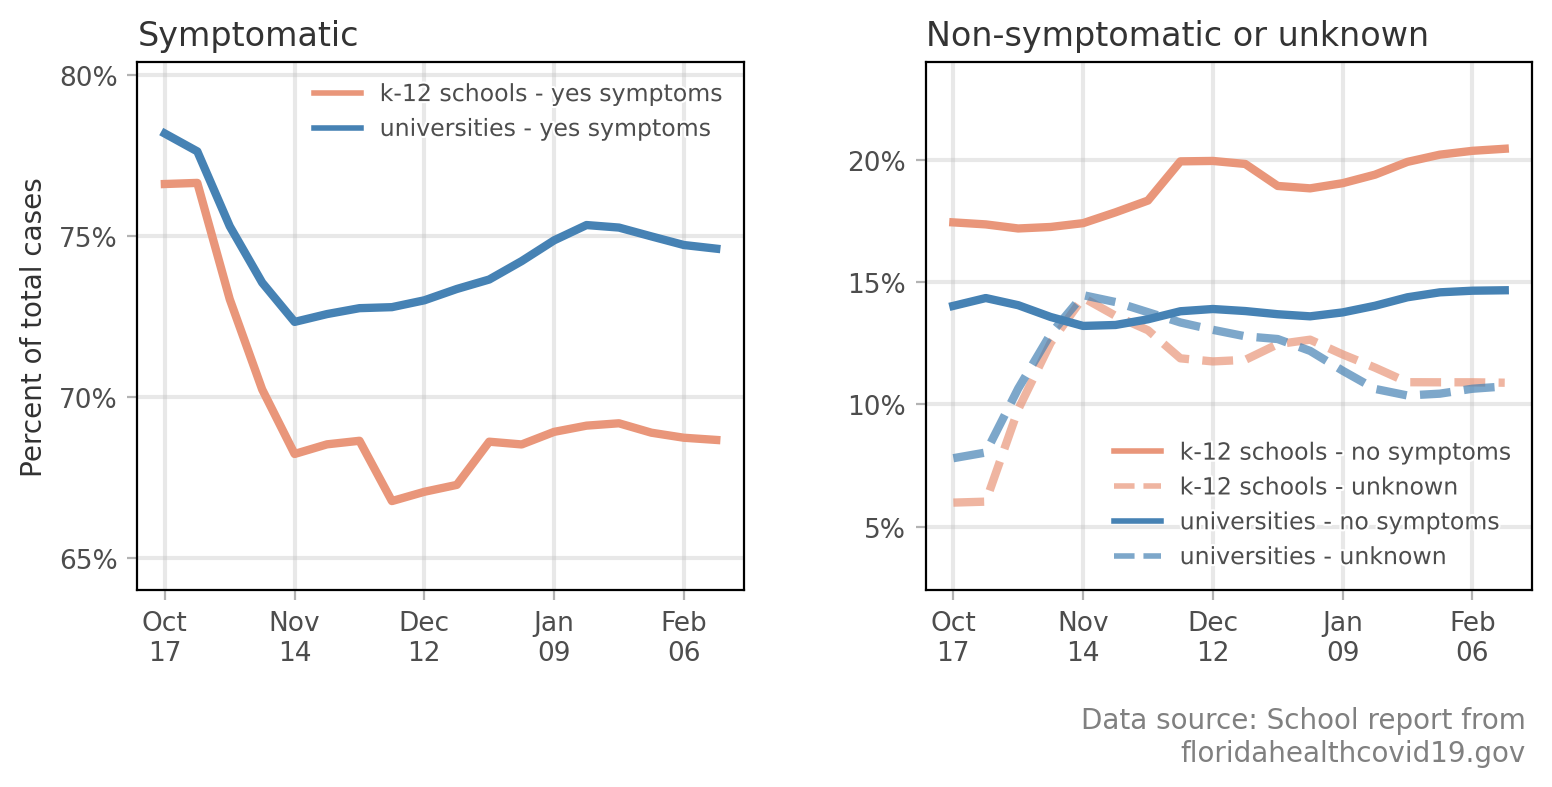

In [330]:
wid = 3
fig, ax = plt.subplots(1,2,figsize=(9,3.5),dpi=200)
plt.subplots_adjust(wspace=0.3)

ax[0].plot(test.loc[test['type']=='k12']['symptoms_yes'].rolling(window=wid).mean().values/\
             test.loc[test['type']=='k12']['cumulative_cases'].rolling(window=wid).mean().values,
           color=cols[1], label='k-12 schools - yes symptoms', lw=lw, linestyle='-')
ax[1].plot(test.loc[test['type']=='k12']['symptoms_no'].rolling(window=wid).mean().values/\
             test.loc[test['type']=='k12']['cumulative_cases'].rolling(window=wid).mean().values,
           color=cols[1], label='k-12 schools - no symptoms', lw=lw, linestyle='-')
ax[1].plot(test.loc[test['type']=='k12']['symptoms_idk'].rolling(window=wid).mean().values/\
             test.loc[test['type']=='k12']['cumulative_cases'].rolling(window=wid).mean().values,
           color=cols[1], label='k-12 schools - unknown', lw=lw, linestyle='--', alpha=0.7)

ax[0].plot(test.loc[test['type']=='university']['symptoms_yes'].rolling(window=wid).mean().values/\
             test.loc[test['type']=='university']['cumulative_cases'].rolling(window=wid).mean().values,
           color=cols[0], label='universities - yes symptoms', lw=lw, linestyle='-')
ax[1].plot(test.loc[test['type']=='university']['symptoms_no'].rolling(window=wid).mean().values/\
             test.loc[test['type']=='university']['cumulative_cases'].rolling(window=wid).mean().values,
           color=cols[0], label='universities - no symptoms', lw=lw, linestyle='-')
ax[1].plot(test.loc[test['type']=='university']['symptoms_idk'].rolling(window=wid).mean().values/\
             test.loc[test['type']=='university']['cumulative_cases'].rolling(window=wid).mean().values,
           color=cols[0], label='universities - unknown', lw=lw, linestyle='--', alpha=0.7)

# plt.ylim(0, 0.25)
dates = test['date'].unique()
for ai, a in enumerate(fig.axes):
    a.tick_params(labelcolor='.3',color='.7',labelsize=9.5)
    a.grid(linewidth=1.5,color='.75',alpha=0.35)
    a.set_xticks(list(range(len(dates)))[2::4])
    a.set_xticklabels([month_dict[i[5:7]]+"\n"+i[8:] for i in sorted(dates)[2::4]])
    leg = a.legend(fontsize=8.5, markerscale=0.5, framealpha=0)
    for line in leg.get_lines():
        line.set_linewidth(lw/1.5)

    for text in leg.get_texts():
        text.set_color('.3')
        text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                               path_effects.Normal()])

    if ai == 0:
        a.set_yticks(np.linspace(0.65,0.8,4))
        a.set_yticklabels(['65%','70%','75%','80%'])
        a.set_ylim(0.64,0.804)
    elif ai == 1:
        a.set_yticks(np.linspace(0.05,0.25,5))
        a.set_yticklabels(['5%','10%','15%','20%','25%'])
        a.set_ylim(0.024,0.24)


ax[0].set_ylabel('Percent of total cases', color='.2')
ax[0].set_title('Symptomatic', x=0, ha='left', color='.2')
ax[1].set_title('Non-symptomatic or unknown', x=0, ha='left', color='.2')
ax[-1].text(0.99,-0.22, 'Data source: School report from'+\
               '\nfloridahealthcovid19.gov',transform=ax[-1].transAxes,
               va='top', ha='right', color='.5')

# plt.savefig('../figs/pngs/florida_schools_symptoms.png',dpi=425,bbox_inches='tight')

plt.show()

In [282]:
# fl_df_g.to_csv('../data/florida_schools.csv',index=False)

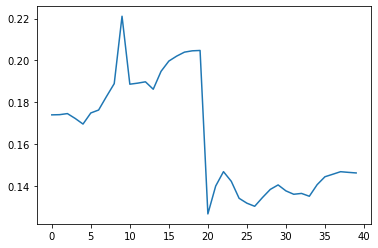

In [257]:
plt.plot(test['symptoms_no'] / test['cumulative_cases'])